In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
from nipype.interfaces import ants

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import subprocess

In [2]:
import sys
import os
rootdir = './modules'
#rootdir = '../modules'
for subdir, dirs, files in os.walk(rootdir):
    sys.path.append(subdir)
    
import mfield
import mriDataAnalysis as mri

# Simulations of transverse relaxation in N1: Static dephasing and Monte Carlo simulation

## Simulation parameters

In [97]:
B0=7. # Tesla
voxelsize = 220. # µm
TE=50 #ms maximal echo time
TESE = np.array([11,16,25,37,56,83])
T = np.arange(0,TE,.1)
dt = 0.1
N = 1e6

## Generate susceptibility map

### Define four voxels of interest

Load 3D susceptibility map with 10 µm slice thickness

In [4]:
sncropdir = '/data/pt_02093/new_data_structure/SN2/posterior-de-ironing/LightMicroscopy/2018-12-04-Perls/sncrop/'

In [5]:
susceptibility = sitk.ReadImage(sncropdir+'n1/cut/susmap3Dironmap.nii')

Load interpolated, isotopically resolved susceptibility map.

In [6]:
susIsoBS3 = sitk.ReadImage(sncropdir+'n1/cut/susIsoBS3new3Dironmap.nii')

In [7]:
susMapA = sitk.GetArrayFromImage(susIsoBS3) 

Cut out four voxels of interst

In [8]:
xstart = 1250
ystart = 650

In [9]:
sidelength = int(np.round(500/susIsoBS3.GetSpacing()[0])) 
susMap4Voxel = susMapA[:,::-1,:][:,xstart:(xstart+sidelength),ystart:(ystart+sidelength)]

In [10]:
voxelpixel = int(np.round(voxelsize/susIsoBS3.GetSpacing()[0])) # pixel for 220 µm "voxel"
borderspacing = susMap4Voxel.shape[2]//2-voxelpixel;borderspacing

34

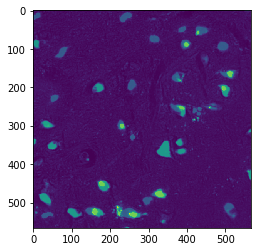

In [11]:
plt.imshow(susMap4Voxel[0,:,:])

## Volume fraction

In [13]:
iron = sitk.ReadImage(sncropdir+'n1/cut/iron3Dironmap.nii')
dnmask = sitk.ReadImage(sncropdir+'n1/cut/dnmask.nii')

In [14]:
ironA = sitk.GetArrayFromImage(iron)[:,::-1,:][:,xstart:(xstart+sidelength),ystart:(ystart+sidelength)]

dnmaskA = sitk.GetArrayFromImage(dnmask)[:,::-1,:][:,xstart:(xstart+sidelength),ystart:(ystart+sidelength)]

In [15]:
dnmask4Voxel = dnmaskA

The volume fraction in percent of DN in the simulated 4 voxel volume

In [16]:
zeta = np.mean(dnmask4Voxel)/255;100*zeta

2.6229880241313017

## Iron fraction in DN

In [17]:
meanIronFer = (ironA*(dnmaskA<127)).mean();meanIronFer

51.135850505435464

In [18]:
meanIronNM = (ironA*(dnmaskA>127)).mean();meanIronNM

8.897047270834685

In [19]:
dnmean=ironA[np.where(dnmaskA>127)].mean()
fermean = ironA[np.where(dnmaskA<127)].mean()

In [20]:
Ndn = (dnmaskA>127).sum()
Nbg = (dnmaskA<127).sum()

std error of mean iron content in DN

In [21]:
sigDNfe=5
sigTissueDNfe = sigDNfe*meanIronNM/350 # the average iron concentration in DN
sigTissueDNfe

0.12710067529763835

Std error of mean fer

In [22]:
sigFTfe = 3

In [23]:
P=zeta*dnmean/(zeta*dnmean + (1-zeta) * fermean);P

0.14839130709125592

In [24]:
sigP = np.sqrt(sigDNfe**2*(zeta*(zeta*dnmean+(1-zeta)*fermean)-zeta**2*dnmean)**2+sigFTfe**2*(zeta*(1-zeta)*dnmean))/(zeta*dnmean+ (1-zeta)*fermean);sigP

0.184751813284556

## Nanoscale relaxation

In [25]:
r2NM = 0.8
r2fer =0.02

In [26]:
R2nanoNM = meanIronNM * r2NM;R2nanoNM

7.117637816667749

In [27]:
meanIronNM

8.897047270834685

In [28]:
sigR2nanoNM= sigTissueDNfe*r2NM;sigR2nanoNM

0.10168054023811068

In [29]:
R2nanoFer = meanIronFer * r2fer;R2nanoFer

1.0227170101087093

In [30]:
sigR2nanoFer= 3*r2fer;sigR2nanoFer

0.06

In [31]:
R2nano = R2nanoNM+R2nanoFer;R2nano

8.140354826776457

In [32]:
sigR2nano = np.sqrt(sigR2nanoFer**2 + sigR2nanoNM**2);sigR2nano

0.11806325534692852

## Susceptibility contributions

In [33]:
ironFerMean = ironA[np.where(dnmaskA<=127)].mean()
ironNMMean  = ironA[np.where(dnmaskA>127)].mean() # ppm 

In [34]:
ironFerMean

52.51121366549189

In [35]:
ironNMMean

339.6882829198418

In [36]:
ironNMMean/ironFerMean

6.46887129830462

In [37]:
susNM = 3.275
susFer = 1.375388026607539

In [38]:
susA = sitk.GetArrayViewFromImage(susceptibility)[:,::-1,:][:,xstart:(xstart+sidelength),ystart:(ystart+sidelength)]

In [39]:
chiMean = susA.mean();chiMean

99.43833389448463

In [40]:
chiDN = susA[np.where(dnmaskA>127)].mean();chiDN

1111.2904937037351

In [41]:
cFeDN = ironNMMean
sigChiDN = chiDN / cFeDN *sigDNfe;sigChiDN

16.35750406448333

In [42]:
susNM = 3.275
susFer = 1.375388026607539

In [43]:
chiMean =  meanIronNM * susNM +  meanIronFer * susFer;chiMean

99.4694663275526

In [44]:
sigChiMean = susNM * sigTissueDNfe + susFer * sigFTfe;sigChiMean

4.542418791422382

In [45]:
zeta = (dnmaskA>127).mean();zeta

0.026191799123475135

In [46]:
psusDN = chiDN*zeta/chiMean;psusDN*100

29.261941833554722

In [47]:
sigPsusDN = (sigChiDN)*(( zeta*chiMean-chiDN*zeta**2)/chiMean**2) ;sigPsusDN*100

0.304681239766752

## Yablonskiy theory

In [48]:
chiDN = ironNMMean*susNM
chiFer = ironFerMean * susFer 
deltaChi = chiDN - chiFer;deltaChi

1040.2558320243343

In [49]:
B0 = 7

In [50]:
deltaomega = 1/3 * mfield.gamma2pi * 2 *np.pi * B0 *deltaChi*1e-9;deltaomega

649.3468760542908

In [51]:
R2pDN = 1.21*zeta*deltaomega;R2pDN

20.57915115627481

In [52]:
sigCNM = 5
sigCFT = 3
sigDeltaChi = np.sqrt(susNM**2*sigCNM**2 + susFer**2*sigCFT**2)

In [53]:
sigDeltaChi

16.88685450324063

In [54]:
sigDeltaomega = 1/3 * mfield.gamma2pi * 2*np.pi*B0 *sigDeltaChi*1e-9;sigDeltaomega

10.541086029504834

In [55]:
sigR2pDN = 1.21*zeta*sigDeltaomega;sigR2pDN

0.33406890947195345

## Static dephasing

In [56]:
susMap4VoxelSA=susMap4Voxel.swapaxes(0,1).swapaxes(1,2)

In [57]:
dfN1 = mfield.genDf(susMap4VoxelSA*1e-9,B0,0)

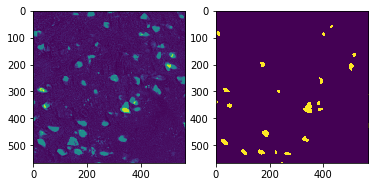

In [60]:
plt.subplot(121)
plt.imshow(susMap4VoxelSA[:,:,-5])
plt.subplot(122)
plt.imshow(dnmask4Voxel[0,:,:])

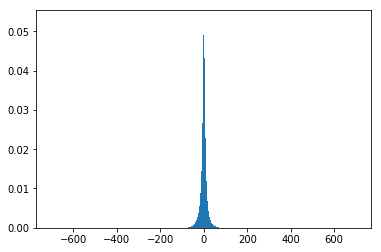

In [61]:
dfN1tot = dfN1[borderspacing:borderspacing+2*voxelpixel,borderspacing:borderspacing+(2)*voxelpixel,:]  
dfN1tot = dfN1tot-dfN1.mean()
histN1tot=plt.hist(dfN1tot.flatten(),bins=4000,density=1,range=(-700,700))
decayN1tot=np.fft.fftshift(np.fft.fft(histN1tot[0]))
SDtN1tot=np.fft.fftshift(np.fft.fftfreq(histN1tot[1].shape[0]-1, histN1tot[1][1]-histN1tot[1][0]))*1e3 
SDdecayN1tot=np.absolute(decayN1tot)/np.absolute(decayN1tot[np.where(SDtN1tot==0)]) #normalization
statDephDecaytot=interp1d(SDtN1tot, np.absolute(SDdecayN1tot)/np.absolute(SDdecayN1tot[np.where(SDtN1tot==0)]))

## D = .3 µm² /ms

In [62]:
D0 = 0.3
D=D0/.76 # adjust for tissue shrinkage
D_MC = D/susIsoBS3.GetSpacing()[0]

### Monte Carlo

In [63]:
n1dir = '/data/pt_02093/new_data_structure/SN2/posterior-de-ironing/LightMicroscopy/2018-12-04-Perls/sncrop/n1/'

In [65]:
dBN1 = mfield.genDBz(susMap4VoxelSA*1e-9,B0,0) 

In [66]:
    
thisdBN1 = dBN1[borderspacing:borderspacing+2*voxelpixel,borderspacing:borderspacing+(2)*voxelpixel,:]        
thisdBN1img=  sitk.GetImageFromArray(thisdBN1.astype('float32'))
sitk.WriteImage(thisdBN1img, 'n1/cut/dBz/dBz3Dim.nii')

In [67]:
dBnii = n1dir+'cut/dBz/dBz3Dim.nii'
out = n1dir+'monteCarlo/monte_carlo_D_{}_B0_{}3Dim.txt'.format(D0,B0)
store_path = n1dir+'monteCarlo/'
MCexe =('/data/u_mbrammerloh_diss/tools/MCProton/MCproton-mbrammerloh -in '+dBnii+' -out '+out+' -store_path '+store_path+
        ' -dt {} -nprotons {} -TE {} -B0 {} -Dcoeff {}'.format(dt,N,TE,B0,D_MC))
print(MCexe)
subprocess.call(MCexe,shell=True)

/data/u_mbrammerloh_diss/tools/MCProton/MCproton-mbrammerloh -in /data/pt_02093/new_data_structure/SN2/posterior-de-ironing/LightMicroscopy/2018-12-04-Perls/sncrop/n1/cut/dBz/dBz3Dim.nii -out /data/pt_02093/new_data_structure/SN2/posterior-de-ironing/LightMicroscopy/2018-12-04-Perls/sncrop/n1/monteCarlo/monte_carlo_D_0.3_B0_73Dim.txt -store_path /data/pt_02093/new_data_structure/SN2/posterior-de-ironing/LightMicroscopy/2018-12-04-Perls/sncrop/n1/monteCarlo/ -dt 0.1 -nprotons 1000000.0 -TE 50 -B0 7 -Dcoeff 0.4467188334341922


127

#### SE sampling

In [68]:
dBnii =n1dir+'cut/dBz/dBz3Dim.nii'
store_path = n1dir+'monteCarlo/se/'
for tese in TESE:
    out = n1dir+'monteCarlo/se/monte_carlo_D_{}_B0_{}_TE_{}3Dim.txt'.format(D0,B0,tese)
    MCexe =('/data/u_mbrammerloh_diss/tools/MCProton/MCproton-mbrammerloh -in '+dBnii+' -out '+out+' -store_path '+store_path+
        ' -dt {} -nprotons {} -TE {} -B0 {} -Dcoeff {}'.format(dt,N,tese,B0,D))
    print(MCexe)
    subprocess.call(MCexe,shell=True)

/data/u_mbrammerloh_diss/tools/MCProton/MCproton-mbrammerloh -in /data/pt_02093/new_data_structure/SN2/posterior-de-ironing/LightMicroscopy/2018-12-04-Perls/sncrop/n1/cut/dBz/dBz3Dim.nii -out /data/pt_02093/new_data_structure/SN2/posterior-de-ironing/LightMicroscopy/2018-12-04-Perls/sncrop/n1/monteCarlo/se/monte_carlo_D_0.3_B0_7_TE_113Dim.txt -store_path /data/pt_02093/new_data_structure/SN2/posterior-de-ironing/LightMicroscopy/2018-12-04-Perls/sncrop/n1/monteCarlo/se/ -dt 0.1 -nprotons 1000000.0 -TE 11 -B0 7 -Dcoeff 0.39473684210526316
/data/u_mbrammerloh_diss/tools/MCProton/MCproton-mbrammerloh -in /data/pt_02093/new_data_structure/SN2/posterior-de-ironing/LightMicroscopy/2018-12-04-Perls/sncrop/n1/cut/dBz/dBz3Dim.nii -out /data/pt_02093/new_data_structure/SN2/posterior-de-ironing/LightMicroscopy/2018-12-04-Perls/sncrop/n1/monteCarlo/se/monte_carlo_D_0.3_B0_7_TE_163Dim.txt -store_path /data/pt_02093/new_data_structure/SN2/posterior-de-ironing/LightMicroscopy/2018-12-04-Perls/sncrop/n

In [70]:
mc = np.loadtxt(sncropdir+'n1/monteCarlo/monte_carlo_D_0.3_B0_73Dim.txt')

In [71]:
mcse = [np.loadtxt(sncropdir+'n1/monteCarlo/se/monte_carlo_D_0.3_B0_7_TE_'+str(te)+'3Dim.txt') for te in TESE[:]]

## Predict apparent linear R2*

### total

In [72]:
statDephDecaytot=interp1d(SDtN1tot, np.absolute(SDdecayN1tot)/np.absolute(SDdecayN1tot[np.where(SDtN1tot==0)]))

In [73]:
mcDecaytot=interp1d(mc[:,0], mc[:,1])

In [74]:
def expfunct(t,R,B):
    return np.exp(-R*t+B)

In [75]:
TEexp = np.linspace(4,40.74,12)*1e-3;TEexp

array([0.004  , 0.00734, 0.01068, 0.01402, 0.01736, 0.0207 , 0.02404,
       0.02738, 0.03072, 0.03406, 0.0374 , 0.04074])

In [76]:
R2sSDtot = curve_fit(expfunct, TEexp, statDephDecaytot(TEexp*1e3));R2sSDtot

(array([43.06413455,  0.11021044]), array([[5.39400583e-02, 6.85535352e-04],
        [6.85535352e-04, 1.30063373e-05]]))

In [77]:
R2sMCtot = curve_fit(expfunct, TEexp, mcDecaytot(TEexp*1e3));R2sMCtot

(array([40.87271091,  0.09986132]), array([[1.18786750e-01, 1.55206208e-03],
        [1.55206208e-03, 3.01622492e-05]]))

## Predict apparent linear R2

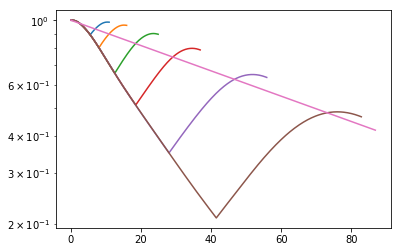

In [78]:
for i in range(6):
    plt.semilogy(mcse[i][:,0], mcse[i][:,2])
plt.plot(np.arange(0,87,.1),np.exp(-10e-3*np.arange(0,87,.1)))

In [79]:
TEse = np.array([mcse[i][-1,0] for i in range(6)])*1e-3
Sse = np.array([mcse[i][-1,2] for i in range(6)])

In [80]:
R2MC = curve_fit(expfunct, np.array(TEse), Sse);R2MC

(array([10.22921229,  0.12065311]), array([[0.26713323, 0.00738127],
        [0.00738127, 0.00030606]]))

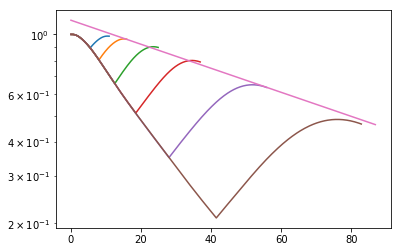

In [81]:
for i in range(6):
    plt.semilogy(mcse[i][:,0], mcse[i][:,2])
plt.plot(np.arange(0,87,.1),expfunct(1e-3*np.arange(0,87,.1),R2MC[0][0], R2MC[0][1]))

0.98496956
0.96050334
0.89520723
0.79088134
0.63630861
0.46613318


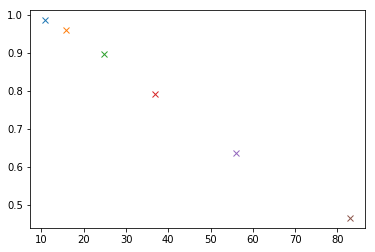

In [82]:
for i in range(6):
    print(mcse[i][-1,2])
    plt.plot(mcse[i][-1,0],mcse[i][-1,2],'x')

# Save data for plotting:

In [93]:
np.save(sncropdir+'n1/plot-data/dfN1tot_3Dim', dfN1tot)

In [94]:
f = open(sncropdir+'n1/plot-data/histSD_3Dim.dat','w')
f.write("#static dephasing decay N1\n")
for i,hist in enumerate(histN1tot[0]):
    f.write(str(np.round(histN1tot[1][i],4))+" "+str(np.round(hist,4))+"\n")
    
f.write(str(np.round(histN1tot[1][i+1],4))+" "+str(0)+"\n")
f.close()

In [95]:
f = open(sncropdir+'n1/plot-data/SSD_3Dim.dat','w')
f.write("#static dephasing decay N1\n")
for i,TT in enumerate(SDtN1tot):
    if TT>=0 and TT<=TE:
        f.write(str(np.round(TT,4))+" "+str(np.round(SDdecayN1tot[i],4))+"\n")
f.close()

In [98]:
f = open(sncropdir+'n1/plot-data/SExp_3Dim.dat','w')
f.write("#experimental values \n")
for i,TT in enumerate(T):
    if TT>=0 and TT<=TE:
        f.write(str(np.round(TT,4))+" "+str(np.round(np.exp(-.040*TT)*mcDecaytot(4)/np.exp(-.040*4),4))+"\n")
f.close()

In [99]:
f = open(sncropdir+'n1/plot-data/SMCSE_3Dim.dat','w')
f.write("#monte carlo spin echo endpoints N1\n")
for i,TT in enumerate(TESE):
    f.write(str(np.round(mcse[i][-1,0],4))+" "+str(np.round(mcse[i][-1,2],4))+"\n")
f.close()